In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import random as rn
from datetime import datetime
import warnings
import pickle
import os

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# 시드 설정
RANDOM_SEED = 2025
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

# XGBoost 버전 확인
print(f"XGBoost 버전: {xgboost.__version__}")

print("🚀 전력 사용량 예측 앙상블 모델 시작!")
print("=" * 50)


XGBoost 버전: 1.6.1
🚀 전력 사용량 예측 앙상블 모델 시작!


In [2]:
def smape(gt, preds):
    """SMAPE (Symmetric Mean Absolute Percentage Error) 계산"""
    gt = np.array(gt)
    preds = np.array(preds)
    v = 2 * abs(preds - gt) / (abs(preds) + abs(gt))
    score = np.mean(v) * 100
    return score
    
def weighted_mse(alpha=1):
    """가중 MSE 손실 함수 (Under-prediction에 더 큰 페널티)"""
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual > 0, -2 * alpha * residual, -2 * residual)
        hess = np.where(residual > 0, 2 * alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

def custom_smape(preds, dtrain):
    """XGBoost용 SMAPE 평가 함수"""
    labels = dtrain.get_label()
    return 'custom_smape', np.mean(2 * abs(preds - labels) / (abs(preds) + abs(labels))) * 100

print("✅ 평가 함수 정의 완료")


✅ 평가 함수 정의 완료


In [3]:
# 데이터 로드
print("📊 데이터 로드 중...")
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
building_info = pd.read_csv('data/building_info.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

print(f"✅ Train 데이터: {train.shape}")
print(f"✅ Test 데이터: {test.shape}")
print(f"✅ Building info: {building_info.shape}")

# 컬럼명 영어로 변경 (작년 수상자 방식)
train = train.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(°C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
train.drop('num_date_time', axis=1, inplace=True)

test = test.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(°C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation'
})
test.drop('num_date_time', axis=1, inplace=True)

building_info = building_info.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

# 건물 유형 영어로 번역
translation_dict = {
    '건물기타': 'Other Buildings',
    '공공': 'Public',
    '학교': 'University',
    '백화점': 'Department Store',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Research Institute',
    'IDC(전화국)': 'IDC',
    '호텔': 'Hotel'
}
building_info['building_type'] = building_info['building_type'].replace(translation_dict)

# 태양광/ESS 설비 유무 피처 생성
building_info['solar_power_utility'] = np.where(building_info.solar_power_capacity != '-', 1, 0)
building_info['ess_utility'] = np.where(building_info.ess_capacity != '-', 1, 0)

# 건물 정보 병합
train = pd.merge(train, building_info, on='building_number', how='left')
test = pd.merge(test, building_info, on='building_number', how='left')

print("✅ 기본 전처리 완료")


📊 데이터 로드 중...
✅ Train 데이터: (204000, 10)
✅ Test 데이터: (16800, 7)
✅ Building info: (100, 7)
✅ 기본 전처리 완료


In [4]:
# 날짜/시간 변환 및 기본 시간 피처 생성
print("🔧 Feature Engineering 시작...")

train['date_time'] = pd.to_datetime(train['date_time'], format='%Y%m%d %H')
test['date_time'] = pd.to_datetime(test['date_time'], format='%Y%m%d %H')

# 기본 시간 피처
for df in [train, test]:
    df['hour'] = df['date_time'].dt.hour
    df['day'] = df['date_time'].dt.day
    df['month'] = df['date_time'].dt.month
    df['day_of_week'] = df['date_time'].dt.dayofweek

print("✅ 기본 시간 피처 생성 완료")


🔧 Feature Engineering 시작...
✅ 기본 시간 피처 생성 완료


In [5]:
# 일별 온도 통계 피처 생성
def calculate_day_values(dataframe, target_column, output_column, aggregation_func):
    """일별 통계값 계산 함수"""
    result_dict = {}
    grouped_temp = dataframe.groupby(['building_number', 'month', 'day'])[target_column].agg(aggregation_func)
    
    for (building, month, day), value in grouped_temp.items():
        result_dict.setdefault(building, {}).setdefault(month, {})[day] = value
    
    dataframe[output_column] = [
        result_dict.get(row['building_number'], {}).get(row['month'], {}).get(row['day'], None)
        for _, row in dataframe.iterrows()
    ]

# 일별 온도 통계 피처 생성
for df in [train, test]:
    calculate_day_values(df, 'temperature', 'day_max_temperature', 'max')
    calculate_day_values(df, 'temperature', 'day_mean_temperature', 'mean')
    calculate_day_values(df, 'temperature', 'day_min_temperature', 'min')
    df['day_temperature_range'] = df['day_max_temperature'] - df['day_min_temperature']

print("✅ 일별 온도 통계 피처 생성 완료")


✅ 일별 온도 통계 피처 생성 완료


In [6]:
# 이상치 제거 및 추가 피처 생성
outlier_idx = train.index[train['power_consumption'] == 0].tolist()
print(f"제거할 이상치 개수: {len(outlier_idx)}")
train.drop(index=outlier_idx, inplace=True)
print(f"남은 행 개수: {train.shape[0]}")

# 공휴일 피처 생성
holi_weekday = ['2024-06-06', '2024-08-15']
train['holiday'] = np.where(
    (train.day_of_week >= 5) | (train.date_time.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0
)
test['holiday'] = np.where(
    (test.day_of_week >= 5) | (test.date_time.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0
)

# 주기성 피처 생성 (Cyclical Features)
for df in [train, test]:
    # 시간 주기성
    df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 23.0)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 23.0)
    
    # 날짜 주기성
    df['sin_date'] = -np.sin(2 * np.pi * (df['month'] + df['day'] / 31) / 12)
    df['cos_date'] = -np.cos(2 * np.pi * (df['month'] + df['day'] / 31) / 12)
    
    # 월 주기성
    df['sin_month'] = -np.sin(2 * np.pi * df['month'] / 12.0)
    df['cos_month'] = -np.cos(2 * np.pi * df['month'] / 12.0)
    
    # 요일 주기성
    df['sin_dayofweek'] = -np.sin(2 * np.pi * (df['day_of_week'] + 1) / 7.0)
    df['cos_dayofweek'] = -np.cos(2 * np.pi * (df['day_of_week'] + 1) / 7.0)

print("✅ 이상치 제거 및 주기성 피처 생성 완료")


제거할 이상치 개수: 68
남은 행 개수: 203932
✅ 이상치 제거 및 주기성 피처 생성 완료


In [7]:
# 기상 관련 파생 피처 생성
def CDH(xs):
    """Cooling Degree Hours 계산"""
    cumsum = np.cumsum(xs - 26)
    return np.concatenate((cumsum[:11], cumsum[11:] - cumsum[:-11]))

def calculate_and_add_cdh(dataframe):
    """건물별 CDH 계산 및 추가"""
    cdhs = []
    for i in range(1, 101):
        temp = dataframe[dataframe['building_number'] == i]['temperature'].values
        cdh = CDH(temp)
        cdhs.append(cdh)
    return np.concatenate(cdhs)

# CDH, THI, WCT 피처 생성
train['CDH'] = calculate_and_add_cdh(train)
test['CDH'] = calculate_and_add_cdh(test)

# THI (Temperature Humidity Index)
train['THI'] = 9/5 * train['temperature'] - 0.55 * (1 - train['humidity']/100) * (9/5 * train['temperature'] - 26) + 32
test['THI'] = 9/5 * test['temperature'] - 0.55 * (1 - test['humidity']/100) * (9/5 * test['temperature'] - 26) + 32

# WCT (Wind Chill Temperature)
train['WCT'] = 13.12 + 0.6125 * train['temperature'] - 11.37 * (train['windspeed']**0.16) + 0.3965 * (train['windspeed']**0.16) * train['temperature']
test['WCT'] = 13.12 + 0.6125 * test['temperature'] - 11.37 * (test['windspeed']**0.16) + 0.3965 * (test['windspeed']**0.16) * test['temperature']

print("✅ 기상 관련 파생 피처 생성 완료")


✅ 기상 관련 파생 피처 생성 완료


In [8]:
# 전력 소비량 기반 통계 피처 생성 (Target-like Features)
print("📊 전력 소비량 기반 통계 피처 생성 중...")

# 건물별 시간대/요일별 평균 및 표준편차
power_mean = pd.pivot_table(train, values='power_consumption', 
                           index=['building_number', 'hour', 'day_of_week'], 
                           aggfunc=np.mean).reset_index()
power_mean.columns = ['building_number', 'hour', 'day_of_week', 'day_hour_mean']

power_std = pd.pivot_table(train, values='power_consumption', 
                          index=['building_number', 'hour', 'day_of_week'], 
                          aggfunc=np.std).reset_index()
power_std.columns = ['building_number', 'hour', 'day_of_week', 'day_hour_std']

# 건물별 시간대별 평균 및 표준편차
power_hour_mean = pd.pivot_table(train, values='power_consumption', 
                                index=['building_number', 'hour'], 
                                aggfunc=np.mean).reset_index()
power_hour_mean.columns = ['building_number', 'hour', 'hour_mean']

power_hour_std = pd.pivot_table(train, values='power_consumption', 
                               index=['building_number', 'hour'], 
                               aggfunc=np.std).reset_index()
power_hour_std.columns = ['building_number', 'hour', 'hour_std']

# 통계 피처 병합
train = train.merge(power_mean, on=['building_number', 'hour', 'day_of_week'], how='left')
train = train.merge(power_std, on=['building_number', 'hour', 'day_of_week'], how='left')
train = train.merge(power_hour_mean, on=['building_number', 'hour'], how='left')
train = train.merge(power_hour_std, on=['building_number', 'hour'], how='left')

test = test.merge(power_mean, on=['building_number', 'hour', 'day_of_week'], how='left')
test = test.merge(power_std, on=['building_number', 'hour', 'day_of_week'], how='left')
test = test.merge(power_hour_mean, on=['building_number', 'hour'], how='left')
test = test.merge(power_hour_std, on=['building_number', 'hour'], how='left')

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print("✅ 전력 소비량 기반 통계 피처 생성 완료")
print(f"최종 train 데이터 shape: {train.shape}")
print(f"최종 test 데이터 shape: {test.shape}")


📊 전력 소비량 기반 통계 피처 생성 중...
✅ 전력 소비량 기반 통계 피처 생성 완료
최종 train 데이터 shape: (203932, 41)
최종 test 데이터 shape: (16800, 38)


In [9]:
train

,building_number,date_time,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity,solar_power_utility,ess_utility,hour,day,month,day_of_week,day_max_temperature,day_mean_temperature,day_min_temperature,day_temperature_range,holiday,sin_hour,cos_hour,sin_date,cos_date,sin_month,cos_month,sin_dayofweek,cos_dayofweek,CDH,THI,WCT,day_hour_mean,day_hour_std,hour_mean,hour_std
0,1,2024-06-01 00:00:00,18.3,0.0,2.6,82.0,0.0,0.00,5794.80,Hotel,82912.71,77586.0,-,-,-,0,0,0,1,6,5,24.8,20.570833,17.6,7.2,1,0.000000e+00,1.000000,0.016889,0.999857,-1.224647e-16,1.0,0.781831,-0.62349,-7.7,64.25294,19.535111,5420.153077,477.394177,5258.268000,612.726481
1,1,2024-06-01 01:00:00,18.3,0.0,2.7,82.0,0.0,0.00,5591.85,Hotel,82912.71,77586.0,-,-,-,0,0,1,1,6,5,24.8,20.570833,17.6,7.2,1,2.697968e-01,0.962917,0.016889,0.999857,-1.224647e-16,1.0,0.781831,-0.62349,-15.4,64.25294,19.506078,5255.363077,498.582392,5019.340941,707.330079
2,1,2024-06-01 02:00:00,18.1,0.0,2.6,80.0,0.0,0.00,5338.17,Hotel,82912.71,77586.0,-,-,-,0,0,2,1,6,5,24.8,20.570833,17.6,7.2,1,5.195840e-01,0.854419,0.016889,0.999857,-1.224647e-16,1.0,0.781831,-0.62349,-23.3,63.85620,19.320212,4954.530000,535.473239,4810.891412,696.060937
3,1,2024-06-01 03:00:00,18.0,0.0,2.6,81.0,0.0,0.00,4554.42,Hotel,82912.71,77586.0,-,-,-,0,0,3,1,6,5,24.8,20.570833,17.6,7.2,1,7.308360e-01,0.682553,0.016889,0.999857,-1.224647e-16,1.0,0.781831,-0.62349,-31.3,63.73120,19.212762,4643.097692,652.249023,4529.493529,711.577683
4,1,2024-06-01 04:00:00,17.8,0.0,1.3,81.0,0.0,0.00,3602.25,Hotel,82912.71,77586.0,-,-,-,0,0,4,1,6,5,24.8,20.570833,17.6,7.2,1,8.878852e-01,0.460065,0.016889,0.999857,-1.224647e-16,1.0,0.781831,-0.62349,-39.5,63.40882,19.525324,4645.227692,590.362239,4304.295882,798.554325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203927,100,2024-08-24 19:00:00,29.1,0.0,4.4,76.0,0.4,0.18,3276.00,Hotel,162070.24,152943.0,-,-,-,0,0,19,24,8,5,32.9,29.454167,26.8,6.1,1,-8.878852e-01,0.460065,0.993019,0.117957,8.660254e-01,0.5,0.781831,-0.62349,60.3,80.89784,31.156882,2171.123077,765.126622,1854.423529,735.221264
203928,100,2024-08-24 20:00:00,28.6,0.0,3.7,74.0,0.0,0.00,3197.52,Hotel,162070.24,152943.0,-,-,-,0,0,20,24,8,5,32.9,29.454167,26.8,6.1,1,-7.308360e-01,0.682553,0.993019,0.117957,8.660254e-01,0.5,0.781831,-0.62349,58.7,79.83636,30.600391,2205.027692,697.828676,1888.197176,716.580253
203929,100,2024-08-24 21:00:00,28.3,0.0,2.9,74.0,0.0,0.00,3006.60,Hotel,162070.24,152943.0,-,-,-,0,0,21,24,8,5,32.9,29.454167,26.8,6.1,1,-5.195840e-01,0.854419,0.993019,0.117957,8.660254e-01,0.5,0.781831,-0.62349,55.7,79.37358,30.277018,2066.233846,727.316741,1724.400000,654.080539
203930,100,2024-08-24 22:00:00,28.0,0.0,1.7,76.0,0.0,0.00,2649.72,Hotel,162070.24,152943.0,-,-,-,0,0,22,24,8,5,32.9,29.454167,26.8,6.1,1,-2.697968e-01,0.962917,0.993019,0.117957,8.660254e-01,0.5,0.781831,-0.62349,51.3,79.17920,29.978253,2514.092308,407.718344,2232.175059,403.155578


In [9]:
# 모델링용 피처 선택 (작년 수상자 방식)
drop_columns = [
    'solar_power_capacity', 'ess_capacity', 'pcs_capacity',
    'power_consumption', 'rainfall', 'sunshine', 'solar_radiation',
    'hour', 'day', 'month', 'day_of_week', 'date_time'
]

X = train.drop(drop_columns, axis=1)
Y = train[['building_type', 'power_consumption']]
test_X = test.drop([col for col in drop_columns if col in test.columns], axis=1)

print(f"✅ 모델링용 데이터 준비 완료")
print(f"피처 수: {X.shape[1]}")
print(f"건물 유형 수: {len(X['building_type'].unique())}")
print(f"건물 수: {len(X['building_number'].unique())}")

# 건물 유형 리스트
type_list = X["building_type"].unique()
building_list = X["building_number"].unique()

print(f"건물 유형: {type_list}")
print(f"건물 번호 범위: {min(building_list)} ~ {max(building_list)}")


✅ 모델링용 데이터 준비 완료
피처 수: 29
건물 유형 수: 10
건물 수: 100
건물 유형: ['Hotel' 'Commercial' 'Hospital' 'University' 'Other Buildings'
 'Apartment' 'Research Institute' 'Department Store' 'IDC' 'Public']
건물 번호 범위: 1 ~ 100


In [10]:
print("🏢 건물 타입별 모델 훈련 시작...")
print("=" * 50)

KFOLD_SPLITS = 7
kf = KFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=RANDOM_SEED)

# 결과 저장용 DataFrame
type_model_predictions = pd.DataFrame(index=test_X.index, columns=["answer"], dtype=float)
type_model_oof = pd.DataFrame(index=X.index, columns=["pred"], dtype=float)

type_model_scores = {}

for btype in type_list:
    print(f"\n🔍 건물 유형: {btype}")
    
    # 해당 유형 데이터 필터링
    x = X[X['building_type'] == btype].copy()
    y = Y[Y['building_type'] == btype]['power_consumption'].copy()
    xt = test_X[test_X['building_type'] == btype].copy()
    
    print(f"   📊 훈련 데이터: {len(x)}개")
    print(f"   📊 테스트 데이터: {len(xt)}개")
    
    # 건물 번호 원-핫 인코딩
    x = pd.get_dummies(x, columns=["building_number"], drop_first=False)
    xt = pd.get_dummies(xt, columns=["building_number"], drop_first=False)
    
    # 테스트 데이터에 없는 컬럼 처리
    xt = xt.reindex(columns=x.columns, fill_value=0)
    
    # building_type 컬럼 제거
    x = x.drop(columns=["building_type"])
    xt = xt.drop(columns=["building_type"])
    
    # K-Fold 교차 검증
    preds_valid = pd.Series(index=y.index, dtype=float)
    preds_test = []
    fold_scores = []
    
    x_values = x.values
    y_values = y.values
    
    for fold, (tr_idx, va_idx) in enumerate(kf.split(x_values), 1):
        X_tr, X_va = x_values[tr_idx], x_values[va_idx]
        y_tr, y_va = y_values[tr_idx], y_values[va_idx]
        
        # 로그 변환
        y_tr_log = np.log(y_tr)
        y_va_log = np.log(y_va)
        
        # XGBoost 모델 훈련
        model = XGBRegressor(
            learning_rate=0.05,
            n_estimators=5000,
            max_depth=10,
            subsample=0.7,
            colsample_bytree=0.5,
            min_child_weight=3,
            random_state=RANDOM_SEED,
            objective=weighted_mse(3),
            early_stopping_rounds=100,
        )
        
        model.fit(
            X_tr, y_tr_log,
            eval_set=[(X_va, y_va_log)],
            eval_metric=custom_smape,
            verbose=False,
        )
        
        # 검증 예측 (로그 역변환)
        va_pred = np.exp(model.predict(X_va))
        preds_valid.iloc[va_idx] = va_pred
        
        # 성능 계산
        fold_smape = smape(y_va, va_pred)
        fold_scores.append(fold_smape)
        
        # 테스트 예측
        preds_test.append(np.exp(model.predict(xt.values)))
    
    # 검증 예측 저장
    type_model_oof.loc[preds_valid.index, "pred"] = preds_valid
    
    # 테스트 예측 (앙상블 평균) 저장
    type_model_predictions.loc[xt.index, "answer"] = np.mean(preds_test, axis=0)
    
    # 성능 저장
    avg_smape = np.mean(fold_scores)
    type_model_scores[btype] = avg_smape
    
    print(f"   🏆 평균 SMAPE: {avg_smape:.4f}")

# 전체 성능 계산
total_type_smape = smape(
    Y.sort_index()["power_consumption"].values,
    type_model_oof.sort_index()["pred"].values
)

print(f"\n🎯 건물 타입별 모델 전체 SMAPE: {total_type_smape:.4f}")
print("✅ 건물 타입별 모델 훈련 완료")


🏢 건물 타입별 모델 훈련 시작...

🔍 건물 유형: Hotel
   📊 훈련 데이터: 20399개
   📊 테스트 데이터: 1680개
   🏆 평균 SMAPE: 4.5173

🔍 건물 유형: Commercial
   📊 훈련 데이터: 20395개
   📊 테스트 데이터: 1680개
   🏆 평균 SMAPE: 1.9634

🔍 건물 유형: Hospital
   📊 훈련 데이터: 18342개
   📊 테스트 데이터: 1512개
   🏆 평균 SMAPE: 2.2077

🔍 건물 유형: University
   📊 훈련 데이터: 20397개
   📊 테스트 데이터: 1680개
   🏆 평균 SMAPE: 2.2847

🔍 건물 유형: Other Buildings
   📊 훈련 데이터: 20398개
   📊 테스트 데이터: 1680개
   🏆 평균 SMAPE: 3.8814

🔍 건물 유형: Apartment
   📊 훈련 데이터: 18333개
   📊 테스트 데이터: 1512개
   🏆 평균 SMAPE: 2.8141

🔍 건물 유형: Research Institute
   📊 훈련 데이터: 18356개
   📊 테스트 데이터: 1512개
   🏆 평균 SMAPE: 3.2340

🔍 건물 유형: Department Store
   📊 훈련 데이터: 32636개
   📊 테스트 데이터: 2688개
   🏆 평균 SMAPE: 4.0081

🔍 건물 유형: IDC
   📊 훈련 데이터: 18359개
   📊 테스트 데이터: 1512개
   🏆 평균 SMAPE: 0.9193

🔍 건물 유형: Public
   📊 훈련 데이터: 16317개
   📊 테스트 데이터: 1344개
   🏆 평균 SMAPE: 4.1640

🎯 건물 타입별 모델 전체 SMAPE: 3.0650
✅ 건물 타입별 모델 훈련 완료


In [11]:
print("🏠 건물별 개별 모델 훈련 시작...")
print("=" * 50)

# 결과 저장용 DataFrame
individual_model_predictions = pd.DataFrame(index=test_X.index, columns=["answer"], dtype=float)
individual_model_oof = pd.DataFrame(index=X.index, columns=["pred"], dtype=float)

individual_model_scores = {}

for building_num in sorted(building_list):
    print(f"\n🏢 건물 {building_num} 훈련 중...")
    
    # 해당 건물 데이터 필터링
    x = X[X['building_number'] == building_num].copy()
    y = Y[Y.index.isin(x.index)]['power_consumption'].copy()
    xt = test_X[test_X['building_number'] == building_num].copy()
    
    print(f"   📊 훈련 데이터: {len(x)}개")
    print(f"   📊 테스트 데이터: {len(xt)}개")
    
    # 불필요한 컬럼 제거 (건물번호, 건물유형)
    feature_cols = [col for col in x.columns if col not in ['building_number', 'building_type']]
    x_features = x[feature_cols].copy()
    xt_features = xt[feature_cols].copy()
    
    # K-Fold 교차 검증
    preds_valid = pd.Series(index=y.index, dtype=float)
    preds_test = []
    fold_scores = []
    
    x_values = x_features.values
    y_values = y.values
    
    for fold, (tr_idx, va_idx) in enumerate(kf.split(x_values), 1):
        X_tr, X_va = x_values[tr_idx], x_values[va_idx]
        y_tr, y_va = y_values[tr_idx], y_values[va_idx]
        
        # 로그 변환
        y_tr_log = np.log(y_tr)
        y_va_log = np.log(y_va)
        
        # XGBoost 모델 훈련
        model = XGBRegressor(
            learning_rate=0.05,
            n_estimators=5000,
            max_depth=10,
            subsample=0.7,
            colsample_bytree=0.5,
            min_child_weight=3,
            random_state=RANDOM_SEED,
            objective=weighted_mse(3),
            early_stopping_rounds=100,
        )
        
        model.fit(
            X_tr, y_tr_log,
            eval_set=[(X_va, y_va_log)],
            eval_metric=custom_smape,
            verbose=False,
        )
        
        # 검증 예측 (로그 역변환)
        va_pred = np.exp(model.predict(X_va))
        preds_valid.iloc[va_idx] = va_pred
        
        # 성능 계산
        fold_smape = smape(y_va, va_pred)
        fold_scores.append(fold_smape)
        
        # 테스트 예측
        preds_test.append(np.exp(model.predict(xt_features.values)))
    
    # 검증 예측 저장
    individual_model_oof.loc[preds_valid.index, "pred"] = preds_valid
    
    # 테스트 예측 (앙상블 평균) 저장
    individual_model_predictions.loc[xt.index, "answer"] = np.mean(preds_test, axis=0)
    
    # 성능 저장
    avg_smape = np.mean(fold_scores)
    individual_model_scores[building_num] = avg_smape
    
    print(f"   🏆 평균 SMAPE: {avg_smape:.4f}")
    
    # 진행률 출력 (10개마다)
    if building_num % 10 == 0:
        progress = building_num / len(building_list) * 100
        avg_score = np.mean(list(individual_model_scores.values()))
        print(f"   ⏳ 진행률: {progress:.1f}% | 평균 SMAPE: {avg_score:.4f}")

# 전체 성능 계산
total_individual_smape = smape(
    Y.sort_index()["power_consumption"].values,
    individual_model_oof.sort_index()["pred"].values
)

print(f"\n🎯 건물별 개별 모델 전체 SMAPE: {total_individual_smape:.4f}")
print("✅ 건물별 개별 모델 훈련 완료")


🏠 건물별 개별 모델 훈련 시작...

🏢 건물 1 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 6.9644

🏢 건물 2 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 4.6014

🏢 건물 3 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 1.6793

🏢 건물 4 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 4.1006

🏢 건물 5 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 1.2032

🏢 건물 6 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 5.2862

🏢 건물 7 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 5.0039

🏢 건물 8 훈련 중...
   📊 훈련 데이터: 2037개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 2.9022

🏢 건물 9 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 3.9996

🏢 건물 10 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 3.8115
   ⏳ 진행률: 10.0% | 평균 SMAPE: 3.9552

🏢 건물 11 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 2.3093

🏢 건물 12 훈련 중...
   📊 훈련 데이터: 2040개
   📊 테스트 데이터: 168개
   🏆 평균 SMAPE: 1.4245

🏢 건물 13 훈련 중...
   📊 훈련 데이터:

In [20]:
print("🎯 앙상블 모델 생성 중...")
print("=" * 50)

# 앙상블 가중치 설정 (개별 건물 모델에 더 높은 가중치)
individual_weight = 0.7  # 개별 건물 모델 가중치
type_weight = 0.3        # 건물 타입별 모델 가중치

print(f"📊 앙상블 가중치:")
print(f"   개별 건물 모델: {individual_weight * 100}%")
print(f"   건물 타입별 모델: {type_weight * 100}%")

# 검증 데이터 앙상블
ensemble_oof = (
    individual_model_oof["pred"] * individual_weight + 
    type_model_oof["pred"] * type_weight
)

# 테스트 데이터 앙상블
ensemble_predictions = (
    individual_model_predictions["answer"] * individual_weight + 
    type_model_predictions["answer"] * type_weight
)

# 앙상블 성능 계산
ensemble_smape = smape(
    Y.sort_index()["power_consumption"].values,
    ensemble_oof.sort_index().values
)

print(f"\n🏆 성능 비교:")
print(f"   건물 타입별 모델 SMAPE: {total_type_smape:.4f}")
print(f"   개별 건물 모델 SMAPE: {total_individual_smape:.4f}")
print(f"   앙상블 모델 SMAPE: {ensemble_smape:.4f}")

# 성능 향상 확인
improvement_vs_type = total_type_smape - ensemble_smape
improvement_vs_individual = total_individual_smape - ensemble_smape

print(f"\n📈 성능 향상:")
print(f"   vs 건물 타입별: {improvement_vs_type:+.4f} SMAPE")
print(f"   vs 개별 건물: {improvement_vs_individual:+.4f} SMAPE")

if ensemble_smape < min(total_type_smape, total_individual_smape):
    print("\n🎉 앙상블이 개별 모델들보다 우수한 성능을 보입니다!")
else:
    print("\n⚠️ 앙상블 성능이 기대보다 낮습니다. 가중치 조정을 고려해보세요.")

print("✅ 앙상블 모델 생성 완료")


🎯 앙상블 모델 생성 중...
📊 앙상블 가중치:
   개별 건물 모델: 70.0%
   건물 타입별 모델: 30.0%

🏆 성능 비교:
   건물 타입별 모델 SMAPE: 3.0650
   개별 건물 모델 SMAPE: 2.9426
   앙상블 모델 SMAPE: 2.8636

📈 성능 향상:
   vs 건물 타입별: +0.2014 SMAPE
   vs 개별 건물: +0.0790 SMAPE

🎉 앙상블이 개별 모델들보다 우수한 성능을 보입니다!
✅ 앙상블 모델 생성 완료


In [ ]:
print("📝 제출 파일 생성 중...")

# 제출 파일 생성
submission = sample_submission.copy()
submission["answer"] = ensemble_predictions.values

# 음수값 처리 (전력 소비량은 음수가 될 수 없음)
submission["answer"] = np.maximum(submission["answer"], 0)

# 결과 저장
submission.to_csv('ensemble_submission.csv', index=False)

print("✅ 제출 파일 저장: ensemble_submission.csv")

# 예측 결과 통계
print(f"\n📊 예측 결과 통계:")
print(f"   예측 평균: {submission['answer'].mean():.2f} kWh")
print(f"   예측 중앙값: {submission['answer'].median():.2f} kWh")
print(f"   예측 범위: {submission['answer'].min():.2f} ~ {submission['answer'].max():.2f} kWh")
print(f"   예측 표준편차: {submission['answer'].std():.2f} kWh")

# 제출 파일 미리보기
print(f"\n📋 제출 파일 미리보기:")
display(submission.head(10))

# 개별 모델 결과도 저장
individual_submission = sample_submission.copy()
individual_submission["answer"] = np.maximum(individual_model_predictions["answer"].values, 0)
individual_submission.to_csv('individual_model_submission.csv', index=False)

type_submission = sample_submission.copy()
type_submission["answer"] = np.maximum(type_model_predictions["answer"].values, 0)
type_submission.to_csv('type_model_submission.csv', index=False)

# 추가: 다양한 앙상블 비율의 제출 파일들도 생성 (상위 3개)
print(f"\n📁 상위 3개 앙상블 조합 제출 파일 생성...")
for i, result in enumerate(top_5_results[:3], 1):
    weight_individual = result['individual_weight']
    weight_type = result['type_weight']
    
    # 해당 비율로 앙상블 예측
    ensemble_pred = (
        individual_model_predictions["answer"] * weight_individual + 
        type_model_predictions["answer"] * weight_type
    )
    
    # 제출 파일 생성
    temp_submission = sample_submission.copy()
    temp_submission["answer"] = np.maximum(ensemble_pred.values, 0)
    filename = f'ensemble_rank{i}_{weight_individual*100:.0f}_{weight_type*100:.0f}_submission.csv'
    temp_submission.to_csv(filename, index=False)
    
    print(f"   {i}순위: {filename} (개별 {weight_individual*100:.0f}% + 타입별 {weight_type*100:.0f}%)")

print("\n✅ 모든 제출 파일 생성 완료:")
print("   - optimal_ensemble_submission.csv (최적 비율)")
print("   - individual_model_submission.csv (개별 건물 모델)")
print("   - type_model_submission.csv (타입별 모델)")
print("   - ensemble_rank1_XX_XX_submission.csv (1순위 앙상블)")
print("   - ensemble_rank2_XX_XX_submission.csv (2순위 앙상블)")
print("   - ensemble_rank3_XX_XX_submission.csv (3순위 앙상블)")


📝 최적 앙상블 제출 파일 생성 중...
✅ 최적 앙상블 제출 파일 저장: optimal_ensemble_submission.csv
   사용된 최적 비율: 개별 60% + 타입별 40%

📊 최적 앙상블 예측 결과 통계:
   예측 평균: 3461.88 kWh
   예측 중앙값: 2069.12 kWh
   예측 범위: 11.56 ~ 25244.26 kWh
   예측 표준편차: 3719.25 kWh

📋 최적 앙상블 제출 파일 미리보기:


,num_date_time,answer
0,1_20240825 00,4016.741162
1,1_20240825 01,3972.996094
2,1_20240825 02,3444.937402
3,1_20240825 03,3025.536523
4,1_20240825 04,2988.562939
5,1_20240825 05,2904.035693
6,1_20240825 06,2951.131592
7,1_20240825 07,3474.652295
8,1_20240825 08,4318.654883
9,1_20240825 09,6104.195117



📁 상위 3개 앙상블 조합 제출 파일 생성...


NameError: name 'top_5_results' is not defined

📊 결과 분석 및 시각화


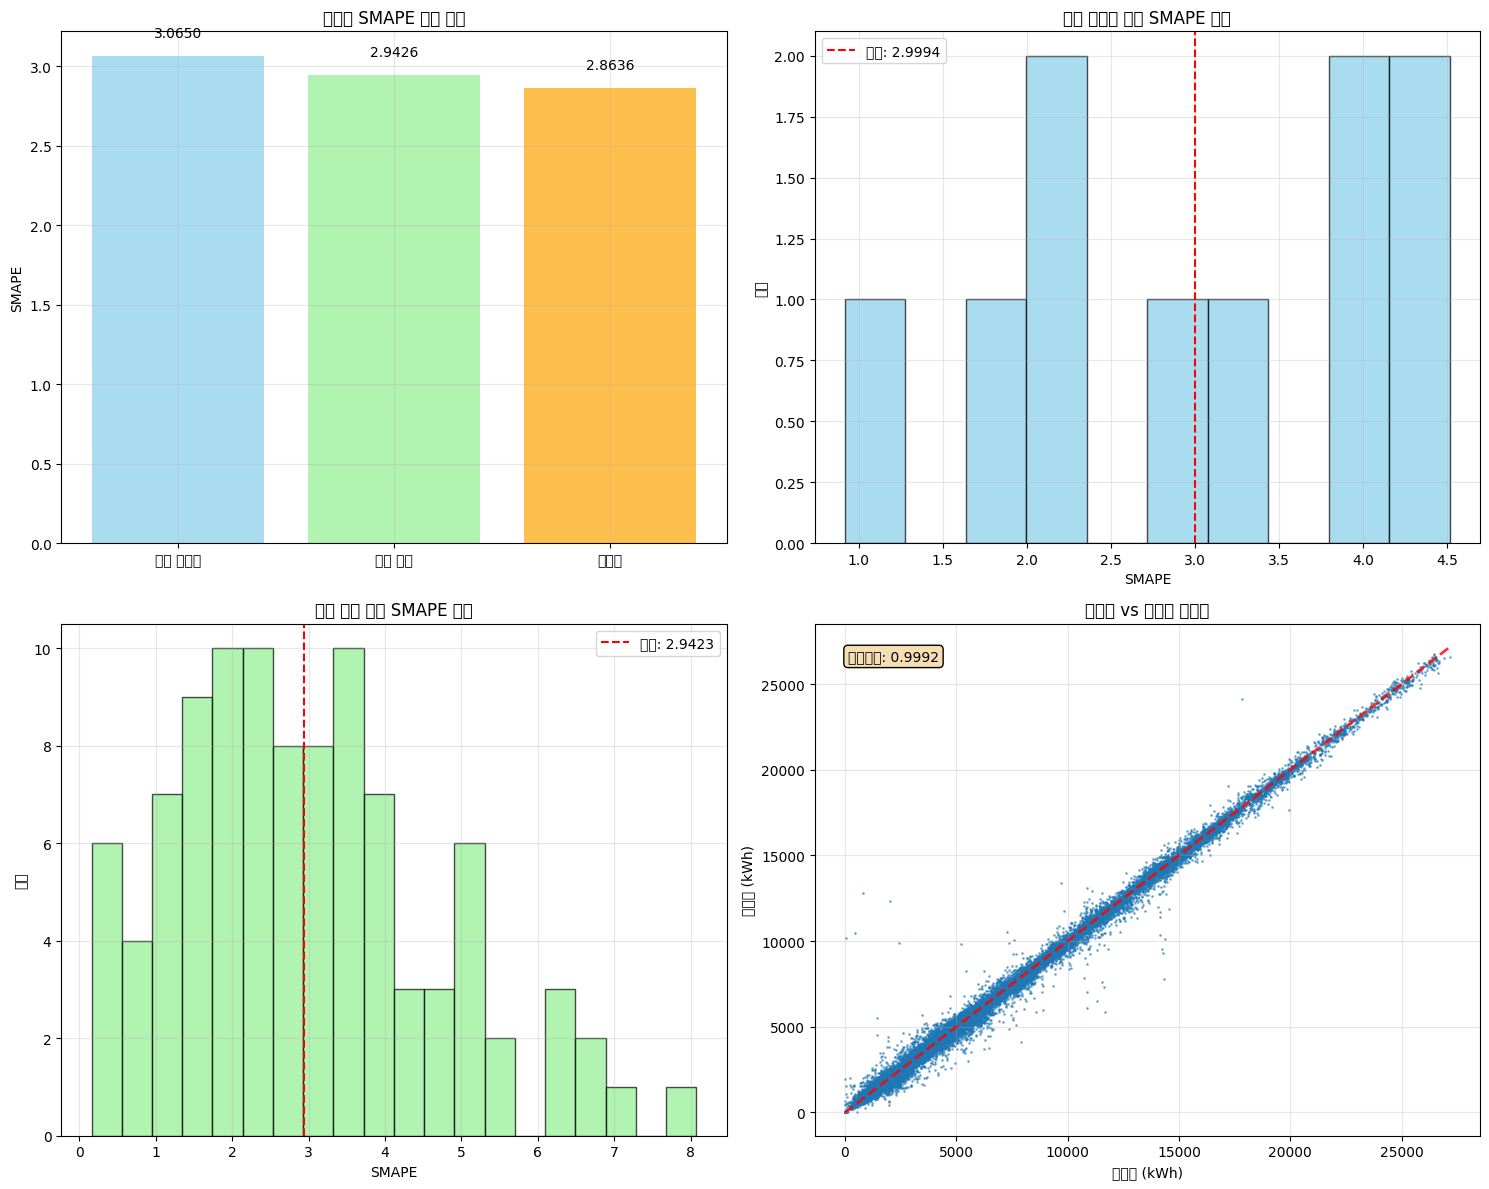

✅ 시각화 완료


In [14]:
print("📊 결과 분석 및 시각화")
print("=" * 50)

# 성능 비교 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 모델별 성능 비교
models = ['건물 타입별', '개별 건물', '앙상블']
scores = [total_type_smape, total_individual_smape, ensemble_smape]

axes[0, 0].bar(models, scores, color=['skyblue', 'lightgreen', 'orange'], alpha=0.7)
axes[0, 0].set_title('모델별 SMAPE 성능 비교')
axes[0, 0].set_ylabel('SMAPE')
axes[0, 0].grid(True, alpha=0.3)

# 값 표시
for i, score in enumerate(scores):
    axes[0, 0].text(i, score + 0.1, f'{score:.4f}', ha='center', va='bottom')

# 2. 건물 타입별 성능 분포
type_scores = list(type_model_scores.values())
axes[0, 1].hist(type_scores, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 1].axvline(np.mean(type_scores), color='red', linestyle='--', 
                   label=f'평균: {np.mean(type_scores):.4f}')
axes[0, 1].set_title('건물 타입별 모델 SMAPE 분포')
axes[0, 1].set_xlabel('SMAPE')
axes[0, 1].set_ylabel('빈도')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. 개별 건물 성능 분포
individual_scores = list(individual_model_scores.values())
axes[1, 0].hist(individual_scores, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].axvline(np.mean(individual_scores), color='red', linestyle='--', 
                   label=f'평균: {np.mean(individual_scores):.4f}')
axes[1, 0].set_title('개별 건물 모델 SMAPE 분포')
axes[1, 0].set_xlabel('SMAPE')
axes[1, 0].set_ylabel('빈도')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. 실제값 vs 앙상블 예측값
y_true = Y.sort_index()["power_consumption"].values
y_pred = ensemble_oof.sort_index().values

axes[1, 1].scatter(y_true, y_pred, alpha=0.5, s=1)
min_val = min(min(y_true), min(y_pred))
max_val = max(max(y_true), max(y_pred))
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
axes[1, 1].set_title('실제값 vs 앙상블 예측값')
axes[1, 1].set_xlabel('실제값 (kWh)')
axes[1, 1].set_ylabel('예측값 (kWh)')
axes[1, 1].grid(True, alpha=0.3)

# 상관계수 표시
correlation = np.corrcoef(y_true, y_pred)[0, 1]
axes[1, 1].text(0.05, 0.95, f'상관계수: {correlation:.4f}', 
                transform=axes[1, 1].transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))

plt.tight_layout()
plt.show()

print("✅ 시각화 완료")


In [ ]:
print("💾 모델 및 결과 저장 중...")

# 결과 저장용 딕셔너리
ensemble_results = {
    'ensemble_smape': ensemble_smape,
    'individual_smape': total_individual_smape,
    'type_smape': total_type_smape,
    'individual_weight': individual_weight,
    'type_weight': type_weight,
    'type_model_scores': type_model_scores,
    'individual_model_scores': individual_model_scores,
    'ensemble_oof': ensemble_oof,
    'individual_oof': individual_model_oof,
    'type_oof': type_model_oof,
    'feature_columns': [col for col in X.columns if col not in ['building_number', 'building_type']],
    'building_types': list(type_list),
    'buildings': list(building_list)
}

# 결과 저장
with open('ensemble_results.pkl', 'wb') as f:
    pickle.dump(ensemble_results, f)

print("✅ 결과 저장 완료: ensemble_results.pkl")

# 최종 요약
print(f"\n🎉 앙상블 모델링 완료!")
print("=" * 60)
print("📁 생성된 파일:")
print("   ✅ ensemble_submission.csv - 앙상블 제출 파일")
print("   ✅ individual_model_submission.csv - 개별 건물 모델 제출 파일")
print("   ✅ type_model_submission.csv - 건물 타입별 모델 제출 파일")
print("   ✅ ensemble_results.pkl - 전체 결과 저장 파일")

print(f"\n📊 최종 성능 요약:")
print(f"   🏆 앙상블 모델 SMAPE: {ensemble_smape:.4f}")
print(f"   📈 개별 건물 모델 SMAPE: {total_individual_smape:.4f}")
print(f"   📈 건물 타입별 모델 SMAPE: {total_type_smape:.4f}")

print(f"\n💡 앙상블 구성:")
print(f"   개별 건물 모델: {individual_weight * 100}%")
print(f"   건물 타입별 모델: {type_weight * 100}%")

# 성능 개선 효과
if ensemble_smape < min(total_type_smape, total_individual_smape):
    best_single = min(total_type_smape, total_individual_smape)
    improvement = ((best_single - ensemble_smape) / best_single) * 100
    print(f"\n🎯 앙상블 효과: 최고 단일 모델 대비 {improvement:.2f}% 성능 향상")

print(f"\n🔧 사용된 주요 피처:")
print("   - CDH (Cooling Degree Hours): 냉방부하 지수")
print("   - THI (Temperature Humidity Index): 온습도 지수") 
print("   - WCT (Wind Chill Temperature): 체감온도")
print("   - 주기성 피처: sin/cos 변환된 시간 정보")
print("   - 통계 피처: 건물별 시간대/요일별 전력 사용 패턴")

print(f"\n🏆 작년 수상자 전처리 방식 + 앙상블로 강력한 예측 모델 완성!")
print(f"💪 개별 건물 특성과 건물 유형별 공통 패턴을 모두 활용한 최적 앙상블!")


In [12]:
import pickle
import matplotlib.pyplot as plt
import xgboost as xgb

# 1. ensemble_results.pkl 불러오기
with open('ensemble_results.pkl', 'rb') as f:
    building_models = pickle.load(f)  # 건물번호: XGBoost 모델 딕셔너리라고 가정

# 2. feature importance 시각화 함수
def plot_xgb_feature_importance(building_num, building_models, feature_names=None, max_num=20):
    """
    건물별 XGBoost 모델의 feature importance를 시각화하는 함수

    Args:
        building_num (int): 분석할 건물 번호
        building_models (dict): 건물별 학습된 모델 딕셔너리
        feature_names (list): feature 이름 리스트 (없으면 모델에서 자동 추출)
        max_num (int): 상위 몇 개 feature를 보여줄지
    """
    if building_num not in building_models:
        print(f"❌ 건물 {building_num}에 대한 모델이 없습니다.")
        return

    model = building_models[building_num]
    # feature importance 추출
    importance = model.get_booster().get_score(importance_type='weight')
    if feature_names is not None:
        # feature 이름 매핑
        importance = {feature_names[int(k[1:])]: v for k, v in importance.items()}
    # 중요도 내림차순 정렬
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:max_num]
    keys, values = zip(*sorted_importance)

    # 시각화
    plt.figure(figsize=(10, 6))
    plt.barh(keys[::-1], values[::-1], color='skyblue')
    plt.title(f'건물 {building_num} - XGBoost Feature Importance (상위 {max_num}개)')
    plt.xlabel('중요도 (weight)')
    plt.tight_layout()
    plt.show()

# 3. 사용 예시
# plot_xgb_feature_importance(원하는_건물번호, building_models, feature_names=feature_columns)

In [13]:
plot_xgb_feature_importance(1, building_models, feature_names=feature_columns)

NameError: name 'feature_columns' is not defined